# Using Supervised Ensemble Methods to Classify Characters in the Script of *Finding Dory*

## Introduction

Can machine learning ensemble classification methods—such as Bagging, Random Forest, Gradient Boosting, AdaBoost, and XGBoost—accurately predict which character delivered a given line from the Finding Dory script?

This project explores the effectiveness of ensemble classification methods in tackling tasks that rely exclusively on text data. Lines from the Finding Dory script are vectorized to serve as independent variables for the models, with the corresponding characters treated as the dependent variable. By analyzing the performance of these models, this study aims to shed light on the limitations of basic text-based classification approaches and underscore the importance of developing more advanced techniques for linguistic and textual classification tasks.

## Load packages

In [54]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score


Please download the following files from `nltk` if they are not already downloaded.

In [2]:
# nltk.download('punkt_tab')
# nltk.download('stopwords')

## Methods

### The Data

The stimuli used in this analysis are lines of dialogue from the script of *Finding Dory* obtained from [Kaggle](https://www.kaggle.com/datasets/ashtrindade/finding-dory-movie-script). The dataset contains two variables:

- `name` (`str`): The name of the character associated with the line
- `line` (`str`): The dialogue delivered by that character

In [4]:
script = pd.read_csv('data/finding_dory.csv')
script.head()

,name,line
0,Young Dory,"Hi, I'm Dory. I suffer from short-term remembe..."
1,Jenny,Yes!
2,Charlie,That's exactly what you say!
3,Jenny,"Okay, okay. We'll pretend to be the other kids..."
4,Charlie,Ahoy there! Do you wanna play hide and seek?


The function `clean_script` pre-processes the text by transforming all letters to lowercase and removing punctuation. To further investigate how pre-processing affects model performance, the `filter_script` function is defined, which removes stopwords from the dialogue.

Using these functions, I created two new variables in the dataframe: 

- `cleaned_line`: line is lowercase, punctuation is removed
- `filtered_line`: line is lowercase, punctuation and stopwords are removed

In [7]:
# function to clean script
def clean_script(text):
    lower_text = text.lower()
    clean_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    return clean_text
    
    
def filter_script(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# clean lines
script['cleaned_line'] = script['line'].apply(clean_script)

# filter out stopwords
script['filtered_line'] = script['cleaned_line'].apply(filter_script)
script.head()

,name,line,cleaned_line,filtered_line
0,Young Dory,"Hi, I'm Dory. I suffer from short-term remembe...",hi im dory i suffer from shortterm remembery loss,hi im dory suffer shortterm remembery loss
1,Jenny,Yes!,yes,yes
2,Charlie,That's exactly what you say!,thats exactly what you say,thats exactly say
3,Jenny,"Okay, okay. We'll pretend to be the other kids...",okay okay well pretend to be the other kids no...,okay okay well pretend kids hi dory
4,Charlie,Ahoy there! Do you wanna play hide and seek?,ahoy there do you wanna play hide and seek,ahoy wan na play hide seek


To simplify the task, the script is further filtered to only include the characters that deliver over 30 lines in the film. However after exploring the data, it seems that "Dory" and "Young Dory" are listed as two separate characters. I then assign all "Young Dory" lines to "Dory".

In [20]:
# keep main characters that have over 30 lines
line_counts = script['name'].value_counts()
main_characters = line_counts[line_counts > 30].index
filtered_script = script[script['name'].isin(main_characters)]

# modify "Young Dory" to "Dory" lines
script['name'] = script['name'].apply(lambda x: 'Dory' if x == 'Young Dory' else x)

print(filtered_script['name'].unique())

['Dory' 'Jenny' 'Charlie' 'Marlin' 'Nemo' 'Hank' 'Fluke' 'Destiny'
 'Bailey']


I then explore the resulting dataframe `script`:

In [21]:
print('Original number of characters: {}'.format(len(script['name'].unique())))
print('Original number of lines: {} \n'.format(len(script)))
print('Number of main characters: {}'.format(len(filtered_script['name'].unique())))
print('Number of filtered lines: {} \n'.format(len(filtered_script)))

Original number of characters: 73
Original number of lines: 1284 

Number of main characters: 9
Number of filtered lines: 1049 



In [42]:
# number of lines from each character
line_dist = filtered_script['name'].value_counts()
line_dist

name
Dory       399
Marlin     162
Hank       119
Destiny     84
Nemo        72
Bailey      66
Charlie     58
Jenny       55
Fluke       34
Name: count, dtype: int64

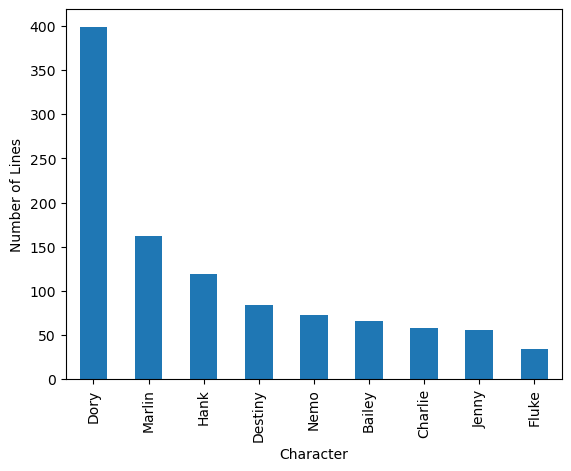

In [53]:
# visualizing line distribution of each character
plt.figure()
line_dist.plot(kind = 'bar')
plt.xlabel('Character')
plt.ylabel('Number of Lines')
plt.show()

After this process, the total number of characters decreased from $73$ to $9$ characters. $235$ lines have been removed.

The distribution of lines among characters is unequal, which is expected since some characters play more prominent roles than others. In an ideal scenario for a classification task, we would aim for a balanced dataset with an equal number of lines per character to ensure fairness and avoid bias. However, for the purposes of this analysis, I have chosen not to further manipulate the data. This decision reflects a preference for preserving the natural distribution, as it provides a more realistic representation of the dataset and aligns with the fact that we naturally have more information about characters with larger roles.

## Using Ensemble Methods

In this project, I explore four types of vectorization methods to convert text data into numerical representations suitable for machine learning. The following code initializes these vectorizers:

- `unigram_vectorizer`: A bag-of-words approach that treats each token independently, without considering its surrounding context.

- `bigram_vectorizer`: Considers pairs of consecutive tokens (bigrams) to capture short-term contextual relationships.

- `trigram_vectorizer`: Extends this concept to sequences of three consecutive tokens (trigrams), providing a broader context.

- `tfidf_vectorizer`: Uses Term Frequency-Inverse Document Frequency (TF-IDF) to assign weights to tokens based on their importance. This approach emphasizes unique terms while downweighting common ones, enabling the model to focus on distinguishing features in the text.

The motivation for experimenting with varying $n$-gram vectorizers is to examine how different levels of contextual information impact model performance. By including TF-IDF, I aim to evaluate the benefits of weighting tokens by relevance rather than relying solely on raw counts or presence indicators.

In [ ]:
### Initialize vectorizers
unigram_vectorizer = CountVectorizer(binary=True)
bigram_vectorizer = CountVectorizer(binary=True, ngram_range=(2,2))
trigram_vectorizer = CountVectorizer(binary=True, ngram_range=(3,3))
tfidf_vectorizer = TfidfVectorizer()

I then initialize the five ensemble classifiers that will be evaluated.

- `Bagging`: Trains multiple decision trees on bootstrapped subsets of the data, then aggregates predictions from multiple models.

- `Random Forest`: Similar to bagging, but selects random subsets of features at each split of the tree.

- `Gradient Boosting`: Trains decision trees sequentially and corrects residual errors made by previous trees.

- `AdaBoosting`: Trains decision trees sequentially and adjusts model weights based on misclassified data points. 

- `XGBoosting`: An optimized version of Gradient Boosting, which includes enhancements like regularization, parallelization of tree construction, and handles missing data more effectively.

All of these models differ in their approach in improving model performance. By comparing these models, we can assess their relative strengths and weaknesses in textual classification tasks.

In [57]:
### Initialize classifiers
# Bagging
dt = DecisionTreeClassifier()
bc = BaggingClassifier(estimator = dt, n_estimators = 100)

# Random forest
rf = RandomForestClassifier(n_estimators = 100, random_state = 12345)

# Gradient boosting
gbr = GradientBoostingClassifier(max_depth = 5, n_estimators = 100, random_state = 12345)

# AdaBoosting
ada = AdaBoostClassifier(estimator = dt, n_estimators = 100, random_state = 12345)

# XGBoosting 
xgb = XGBClassifier(n_estimators = 100, random_state = 12345)

## Analysis: Unfiltered Lines

In [58]:
# Create X and y variables
uni_X = unigram_vectorizer.fit_transform(filtered_script['line'])
bi_X = bigram_vectorizer.fit_transform(filtered_script['line'])
tri_X = trigram_vectorizer.fit_transform(filtered_script['line'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_script['name'])

In [50]:
# Define the models
models = {
    'Logistic Regression': logreg,
    'Bagging Classifier': bc,
    'Random Forest': rf,
    'Gradient Boosting': gbr,
    'AdaBoosting': ada,
    'XGBoosting': xgb}

# Number of folds for cross-validation
cv_folds = 10

In [51]:
def run_model(models, X, y, cv_folds):
    accuracy_scores = []
    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=cv_folds, scoring = 'accuracy')
        accuracy_scores.append({
            'model': model_name,
            'mean_accuracy_score': np.mean(cv_scores)})
    results = pd.DataFrame(accuracy_scores)
    return results

### Comparing models with unigrams, bigrams, and trigrams

In [52]:
run_model(models, uni_X, y, cv_folds)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(uni_X, y, test_size=0.3, random_state=1000)

# Logistic regression
# multinomial logit model
logreg.fit(X_train, y_train)
logreg_y_pred = logreg.predict(X_test)

# Bagging
bc.fit(X_train, y_train)
bc_y_pred = bc.predict(X_test)

# Random forest
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Gradient boosting
gbr.fit(X_train, y_train)
gbr_y_pred = gbr.predict(X_test)

# AdaBoosting
ada.fit(X_train, y_train)
ada_y_pred = ada.predict(X_test)

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# Comparing models
print('Test set Accuracy of Logistic Regression: {:3f}'.format(accuracy_score(y_test, logreg_y_pred)))
print('Test set Accuracy of Bagging Classifier: {:3f}'.format(accuracy_score(y_test, bc_y_pred)))
print('Test set Accuracy of Random Forest: {:3f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Test set Accuracy of Gradient Boosting: {:3f}'.format(accuracy_score(y_test, gbr_y_pred)))
print('Test set Accuracy of AdaBoosting: {:3f}'.format(accuracy_score(y_test, ada_y_pred)))
print('Test set Accuracy of XGBoosting: {:3f}'.format(accuracy_score(y_test, xgb_y_pred)))

## Analysis: Filtered Lines

In [ ]:
filtered_X = unigram_vectorizer.fit_transform(filtered_script['filtered_line'])
X_train, X_test, y_train, y_test = train_test_split(filtered_X, y, test_size=0.3, random_state=1000)

# Logistic regression
# WRONG: use multinomial logistic regression
logreg.fit(X_train, y_train)
logreg_y_pred = logreg.predict(X_test)

# Bagging
bc.fit(X_train, y_train)
bc_y_pred = bc.predict(X_test)

# Random forest
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Gradient boosting
gbr.fit(X_train, y_train)
gbr_y_pred = gbr.predict(X_test)

# AdaBoosting
ada.fit(X_train, y_train)
ada_y_pred = ada.predict(X_test)

# XG Boosting
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# Comparing models
print('Test set Accuracy of Logistic Regression: {:3f}'.format(accuracy_score(y_test, logreg_y_pred)))
print('Test set Accuracy of Bagging Classifier: {:3f}'.format(accuracy_score(y_test, bc_y_pred)))
print('Test set Accuracy of Random Forest: {:3f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Test set Accuracy of Gradient Boosting: {:3f}'.format(accuracy_score(y_test, gbr_y_pred)))
print('Test set Accuracy of AdaBoosting: {:3f}'.format(accuracy_score(y_test, ada_y_pred)))
print('Test set Accuracy of XGBoosting: {:3f}'.format(accuracy_score(y_test, xgb_y_pred)))

In [ ]:
filtered_X = unigram_vectorizer.fit_transform(filtered_script['filtered_line'])
run_model(models, filtered_X, y, cv_folds)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

,model,mean_accuracy_score
0,Logistic Regression,0.418553
1,Bagging Classifier,0.373718
2,Random Forest,0.381364
3,Gradient Boosting,0.394679
4,AdaBoosting,0.355687
5,XGBoosting,0.396621


## Analysis: Using TF-IDF

In [ ]:
tfidf_X = tfidf_vectorizer.fit_transform(filtered_script['filtered_line'])
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.3, random_state=1000)

# Logistic regression
logreg.fit(X_train, y_train)
logreg_y_pred = logreg.predict(X_test)

# Bagging
bc.fit(X_train, y_train)
bc_y_pred = bc.predict(X_test)

# Random forest
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Gradient boosting
gbr.fit(X_train, y_train)
gbr_y_pred = gbr.predict(X_test)

# AdaBoosting
ada.fit(X_train, y_train)
ada_y_pred = ada.predict(X_test)

# XG Boosting
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# Comparing models
print('Test set Accuracy of Logistic Regression: {:3f}'.format(accuracy_score(y_test, logreg_y_pred)))
print('Test set Accuracy of Bagging Classifier: {:3f}'.format(accuracy_score(y_test, bc_y_pred)))
print('Test set Accuracy of Random Forest: {:3f}'.format(accuracy_score(y_test, rf_y_pred)))
print('Test set Accuracy of Gradient Boosting: {:3f}'.format(accuracy_score(y_test, gbr_y_pred)))
print('Test set Accuracy of AdaBoosting: {:3f}'.format(accuracy_score(y_test, ada_y_pred)))
print('Test set Accuracy of XGBoosting: {:3f}'.format(accuracy_score(y_test, xgb_y_pred)))

In [ ]:
tfidf_X = tfidf_vectorizer.fit_transform(filtered_script['filtered_line'])
run_model(models, tfidf_X, y, cv_folds)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

,model,mean_accuracy_score
0,Logistic Regression,0.416676
1,Bagging Classifier,0.417619
2,Random Forest,0.412821
3,Gradient Boosting,0.401364
4,AdaBoosting,0.347088
5,XGBoosting,0.401419


#
# GPT Method
#

## Setting parameters

In [ ]:
# Still not sure if I should update these!!
VOCAB_SIZE = 10000
MAX_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 64
EPOCHS = 25

## Tokenize data

In [ ]:
# Tokenize using nltk's tokenizer
script['line_tokens'] = script['line'].apply(word_tokenize)
# put script tokens into a list
mylist = list(script.line_tokens)
mylist = [' '.join(x) for x in mylist]

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(mylist)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorization layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:15]):
    print(f"{i}: {word}")

In [ ]:
# Display an example line from the script and its vector representation
example = mylist[110]
example_tokenized = vectorize_layer(example)
print(example)
print(example_tokenized.numpy())

## Creating the training set

In [ ]:
# Create training set of bigrams
def prepare_bigrams(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

train_bigrams = text_ds.map(prepare_bigrams)

In [ ]:
# Create training set of trigrams
def prepare_trigrams(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-2]
    y = tokenized_sentences[:, 2:]
    return x, y

train_trigrams = text_ds.map(prepare_trigrams)

Showing example input and output for trigram training set:

In [ ]:
example_input_output = train_trigrams.take(1).get_single_element()

In [ ]:
# Example Input
example_input_output[0][0]

In [ ]:
# Example Output (shifted by two tokens)
example_input_output[1][0]

## Create causal attention mask function

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

## Don't know what to do next...

run a sequential model 
- attention head
- spit out result of attention head
- print result

- do the entire model
- extract what comes out of the attention head